In [ ]:
#%pip install duckdb

In [1]:
%run generate_report.py --season-year 2026

Workout data download completed successfully
Download output: Logging in...
Login successful.
Successfully downloaded and modified season summary to /Users/matthewmartin/concept2/workouts/season_summary_2026.csv
Fetching all season data from https://log.concept2.com/season/2026?per_page=all...
Found profile ID: 2261340
Found 71 workouts. Starting download with 10 parallel workers...
Skipped 2025-07-23_rowerg_detail_workout_104375138.csv (already exists)
Skipped 2025-09-03_skierg_detail_workout_105760031.csv (already exists)
Skipped 2025-07-22_rowerg_detail_workout_104341202.csv (already exists)
Skipped 2025-08-28_skierg_detail_workout_105558781.csv (already exists)
Skipped 2025-08-13_rowerg_detail_workout_105049947.csv (already exists)
Skipped 2025-07-27_skierg_detail_workout_104492315.csv (already exists)
Skipped 2025-07-22_skierg_detail_workout_104340613.csv (already exists)
Skipped 2025-07-27_rowerg_detail_workout_104492314.csv (already exists)
Skipped 2025-07-28_rowerg_detail_worko

In [22]:

%run generate_report.py --season-year 2026 --no-logbook-fetch

Skipping data download (--no-logbook-fetch specified)
Setting up database connection...
Generating PDF report...
Creating pace over time chart...
Saving pace chart to PDF...
Creating monthly meters chart...
Generating PDF report...
Creating pace over time chart...
Saving pace chart to PDF...
Creating monthly meters chart...
PDF report generated successfully: concept2_workout_report.pdf
PDF report generated successfully: concept2_workout_report.pdf


In [2]:
import duckdb
cn = duckdb.connect()
cn.sql("create or replace view v_detail_workouts as select * from read_csv_auto('~/concept2/workouts/*detail*.csv')")
cn.sql("create or replace view v_summary_workouts as select * from read_csv_auto('~/concept2/workouts/*summary*.csv')")    

In [27]:
sql = """
    select "Description", count(*) as cnt
    from v_summary_workouts
    group by all
    order by 2 desc 
"""
cn.sql(sql)

┌──────────────┬───────┐
│ Description  │  cnt  │
│   varchar    │ int64 │
├──────────────┼───────┤
│ 6000m row    │    25 │
│ 30:00 row    │    22 │
│ 8000m row    │    20 │
│ 7000m row    │    12 │
│ 10000m row   │    11 │
│ 1000m SkiErg │     8 │
│ 5000m row    │     7 │
│ 9000m row    │     7 │
│ 3000m row    │     7 │
│ 2000m SkiErg │     6 │
│     ·        │     · │
│     ·        │     · │
│     ·        │     · │
│ 15:04 row    │     1 │
│ 3100m row    │     1 │
│ 32:00 row    │     1 │
│ 20:31 row    │     1 │
│ 26:03 row    │     1 │
│ 26:00 SkiErg │     1 │
│ 3500m SkiErg │     1 │
│ 32:03 row    │     1 │
│ 21:00 SkiErg │     1 │
│ 1600m SkiErg │     1 │
├──────────────┴───────┤
│  87 rows (20 shown)  │
└──────────────────────┘

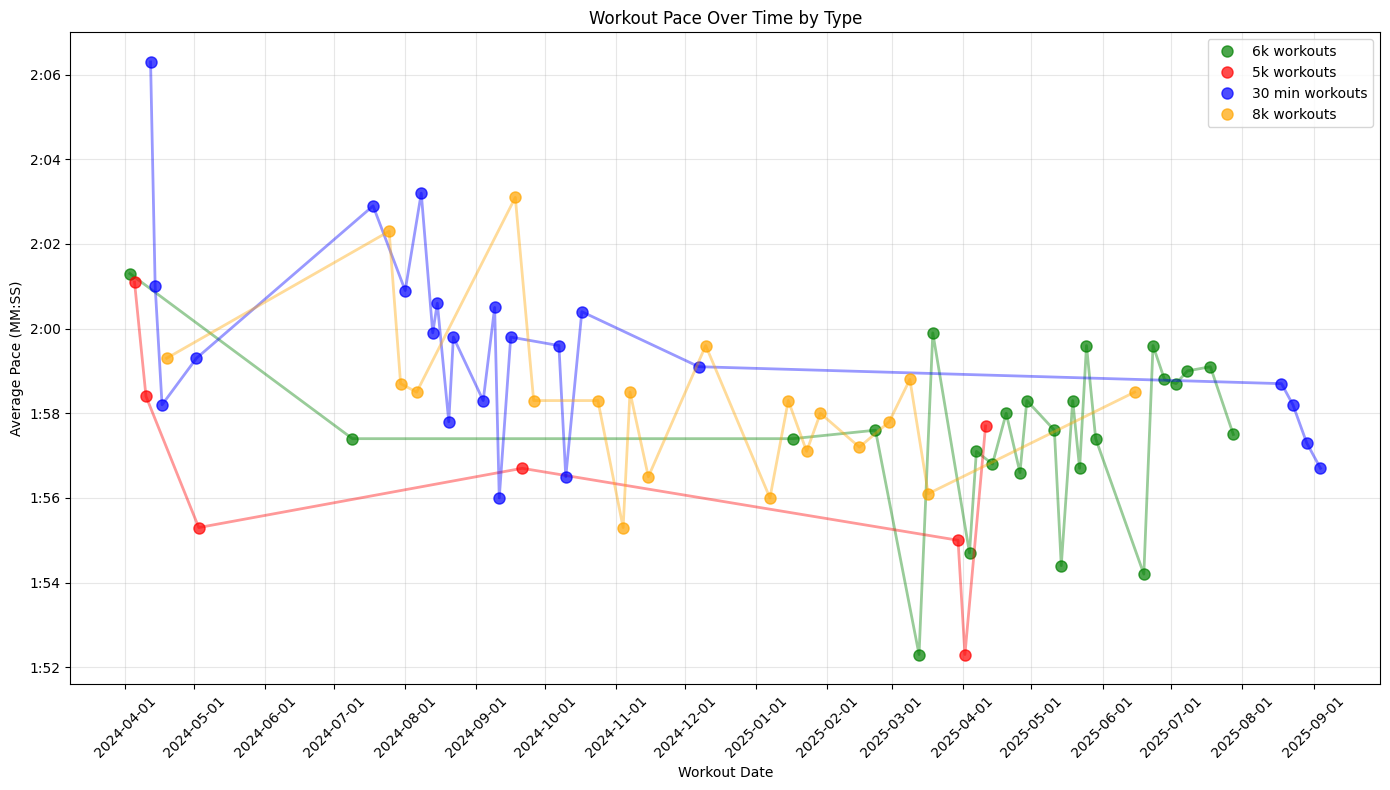


6k workouts:
  Count: 25
  Date range: 2024-04-03 to 2025-07-28
  Best pace: 1:52
  Average pace: 1:57
  Average distance: 6000 meters

5k workouts:
  Count: 7
  Date range: 2024-04-05 to 2025-04-11
  Best pace: 1:52
  Average pace: 1:56
  Average distance: 5000 meters

30 min workouts:
  Count: 23
  Date range: 2024-04-12 to 2025-09-04
  Best pace: 1:56
  Average pace: 1:59
  Average distance: 7524 meters

8k workouts:
  Count: 20
  Date range: 2024-04-19 to 2025-06-15
  Best pace: 1:55
  Average pace: 1:58
  Average distance: 8000 meters


In [28]:
sql = """
    select cast("date" as date) as workout_dt
        , "Pace" as avg_split_str
        , case 
            when "Work Time (Formatted)" = '30:00.0' then '30 min'
            when "Description" = '6000m row' then '6k'
            when "Description" = '5000m row' then '5k'
            when "Description" = '8000m row' then '8k'
        end as workout_type_ind
        , cast("Work Distance" as int) as distance_meters
    from v_summary_workouts
    where 1=1
        and "Pace" is not null
        and (
            "Work Time (Formatted)" = '30:00.0'
            or "Description" = '6000m row'
            or "Description" = '5000m row'
            or "Description" = '8000m row'
        )
    order by workout_dt
"""

import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import pandas as pd
from scipy import stats

# Get the data as a DataFrame
df = cn.sql(sql).df()

# Convert workout_dt to datetime
df['workout_dt'] = pd.to_datetime(df['workout_dt'])

# Convert pace string (MM:SS.s format) to seconds
def pace_to_seconds(pace_str):
    """Convert pace string like '2:15.3' to total seconds"""
    try:
        # Split by colon to get minutes and seconds
        parts = pace_str.split(':')
        minutes = int(parts[0])
        seconds = float(parts[1])
        return minutes * 60 + seconds
    except:
        return None

df['pace_seconds'] = df['avg_split_str'].apply(pace_to_seconds)

# Remove any rows where pace conversion failed
df = df.dropna(subset=['pace_seconds'])

if len(df) == 0:
    print("No workout data found!")
else:
    # Create the plot
    fig, ax = plt.subplots(figsize=(14, 8))
    
    # Define colors for each workout type
    colors = {'30 min': 'blue', '6k': 'green', '5k': 'red', '8k': 'orange'}
    
    # Plot each workout type separately
    for workout_type in df['workout_type_ind'].unique():
        if pd.isna(workout_type):  # Skip any null values
            continue
            
        # Filter data for this workout type
        type_df = df[df['workout_type_ind'] == workout_type].copy()
        type_df = type_df.sort_values('workout_dt')  # Ensure chronological order
        
        color = colors.get(workout_type, 'gray')
        
        # Plot the data points
        ax.plot(type_df['workout_dt'], type_df['pace_seconds'], 
                marker='o', linewidth=0, markersize=8, color=color, alpha=0.7, 
                label=f'{workout_type} workouts')
        
        # Add connecting line for time series
        ax.plot(type_df['workout_dt'], type_df['pace_seconds'], 
                linewidth=2, color=color, alpha=0.4)
    
    # Format y-axis to show pace as MM:SS
    def format_pace(seconds, pos):
        mins = int(seconds // 60)
        secs = int(seconds % 60)
        return f'{mins}:{secs:02d}'
    
    ax.yaxis.set_major_formatter(plt.FuncFormatter(format_pace))
    
    # Format x-axis dates
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
    ax.xaxis.set_major_locator(mdates.MonthLocator())
    plt.xticks(rotation=45)
    
    # Labels and formatting
    ax.set_xlabel('Workout Date')
    ax.set_ylabel('Average Pace (MM:SS)')
    ax.set_title('Workout Pace Over Time by Type')
    ax.grid(True, alpha=0.3)
    ax.legend()
    
    plt.tight_layout()
    plt.show()
    
    # Show statistics for each workout type
    for workout_type in df['workout_type_ind'].unique():
        if pd.isna(workout_type):
            continue
            
        type_df = df[df['workout_type_ind'] == workout_type]
        print(f"\n{workout_type} workouts:")
        print(f"  Count: {len(type_df)}")
        if len(type_df) > 0:
            print(f"  Date range: {type_df['workout_dt'].min().strftime('%Y-%m-%d')} to {type_df['workout_dt'].max().strftime('%Y-%m-%d')}")
            print(f"  Best pace: {format_pace(type_df['pace_seconds'].min(), 0)}")
            print(f"  Average pace: {format_pace(type_df['pace_seconds'].mean(), 0)}")
            print(f"  Average distance: {type_df['distance_meters'].mean():.0f} meters")